In [1]:
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from Domain.Nutzenergieanalyse import NEAData

import Bevoelkerung
import Domain.General
import Energiebilanz
import General
import Nutzenergieanalyse
import Processor
import Utils


def create_general_data(g_laender_factory: Domain.General.GLaenderFactory):
    g_sektoren_factory = General.GSektorenDefaultFactory()
    g_bereiche_factory = General.GBereicheSimpleFactory()
    g_energietraeger_klassen_factory = General.GEnergietraegerKlassenSimpleFactory()
    g_energietraeger_factory = General.GEnergietraegerSimpleFactory()
    g_data_factory = General.GDataFactory(g_laender_factory, g_sektoren_factory, g_bereiche_factory,
                                          g_energietraeger_klassen_factory, g_energietraeger_factory)
    g_data = g_data_factory.create()
    return g_data

def create_nea_data(g_data: Domain.General.GData):
    nea_data_pickle_factory = Nutzenergieanalyse.NEADataPickleFactory(pathlib.Path('Data/Serialization'))
    nea_data_factory = Nutzenergieanalyse.NEADataETKlassenFactory(nea_data_pickle_factory)
    nea_data = nea_data_factory.create(g_data).data
    return {land.name: {sektor.name: {bereich.name: nea_data[land][sektor][bereich] for bereich in nea_data[land][sektor].keys()} for sektor in nea_data[land].keys()} for land in nea_data.keys()}

def create_eb_data(g_data: Domain.General.GData):
    eb_data_pickle_factory = Energiebilanz.EBDataPickleFactory(pathlib.Path('Data/Serialization'))
    eb_data_factory = Energiebilanz.EBDataETKlassenFactory(eb_data_pickle_factory)
    eb_data = eb_data_factory.create(g_data).data
    return {land.name: {sektor.name: eb_data[land][sektor] for sektor in eb_data[land].keys()} for land in eb_data.keys()}

def create_b_data(g_data: Domain.General.GData):
    b_data_factory = Bevoelkerung.BDataPickleFactory(pathlib.Path('Data/Serialization'), list(general_data.laender.values()))
    b_data = b_data_factory.create(list(general_data.laender.values())).data
    def interpolate(bd):
        return pd.Series(bd, pd.period_range('1988', '2040', freq='A')).interpolate()
    return {land.name: interpolate(b_data[land]) for land in b_data.keys()}
    
laender_factory = General.GBundeslaenderFactory()
general_data = create_general_data(laender_factory)

nea_data = create_nea_data(general_data)
eb_data = create_eb_data(general_data)
b_data = create_b_data(general_data)


In [2]:
general_data.bereiche.values()

dict_values([GBereich(name='Heizen'), GBereich(name='Warmwasser und Kochen'), GBereich(name='Strom')])

In [3]:
general_data.sektoren.values()

dict_values([GSektor(name='Wohngebäude'), GSektor(name='Dienstleistungsgebäude'), GSektor(name='Landwirtschaftsgebäude')])

In [4]:
def create_nea_data_sektor(land: str, sektor: str):
    return sum([nea_data[land][sektor][bereich.name] for bereich in general_data.bereiche.values()])

def create_nea_data_land(land: str):
    return sum([create_nea_data_sektor(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_nea_data_bereich_oesterreich(sektor: str, bereich: str):
    return sum([nea_data[land.name][sektor][bereich] for land in general_data.laender.values()])

def create_nea_data_sektor_oesterreich(sektor: str):
    return sum([create_nea_data_sektor(land.name, sektor) for land in general_data.laender.values()])

def create_nea_data_oesterreich():
    return sum([create_nea_data_land(land.name) for land in general_data.laender.values()])

In [5]:
def clean_negative_values(data):
    df = data.copy()
    df[df < 0] = 0
    return df

def calc_relative(df: pd.DataFrame):
    return (df.transpose() / df.sum(axis=1)).transpose()


In [6]:
extrapolation = Utils.DFLinearExtrapolation()
extension = Utils.DFNanExtension()
extrapolation_extension = Utils.DFExtrapolationExtension(extrapolation)
arima = Utils.DFSARIMAXExtrapolation()
arima_extension = Utils.DFExtrapolationExtension(arima)


In [7]:
def extend_nea_data(land: str, sektor: str, bereich: str):
    s = create_nea_data_sektor(land, sektor)
    b = nea_data[land][sektor][bereich]
    rel = (b / s).fillna(0)
    eb = eb_data[land][sektor]
    rel_ex = extrapolation_extension.run(rel, pd.PeriodIndex(pd.period_range(start='1988', end='2020', freq='A'), name=rel.index.name))
    return rel_ex * eb

def extend_all_nea_data():
    return {land: {sektor: {bereich: extend_nea_data(land, sektor, bereich) for bereich in nea_data[land][sektor].keys()} for sektor in nea_data[land].keys()} for land in nea_data.keys()}

nea_data_ex = extend_all_nea_data()


In [8]:
def create_b_laender():
    return pd.DataFrame([b_data[land.name] for land in general_data.laender.values()])

def create_data_bereich_pp(land: str, sektor: str, bereich: str):
    nea = nea_data_ex[land][sektor][bereich]
    return (nea.transpose() / b_data[land]['1988':'2020']).transpose().rolling(3).mean()['1990':]

def create_data_bereich_pp_ex(land: str, sektor: str, bereich: str):
    nea_pp = create_data_bereich_pp(land, sektor, bereich)
    nea_pp_ex = extrapolation_extension.run(nea_pp, pd.PeriodIndex(pd.period_range(start=nea_pp.index[0], end='2040', freq='A'), name=nea_pp.index.name))
    return clean_negative_values(nea_pp_ex)

def create_data_bereich(land: str, sektor: str, bereich: str):
    nea_pp = create_data_bereich_pp(land, sektor, bereich)
    return (nea_pp.transpose() * b_data[land]['1990':'2020']).transpose()

def create_data_bereich_ex(land: str, sektor: str, bereich: str):
    nea = create_data_bereich(land, sektor, bereich)
    nea_ex = extrapolation_extension.run(nea, pd.PeriodIndex(pd.period_range(start=nea.index[0], end='2040', freq='A'), name=nea.index.name))
    return clean_negative_values(nea_ex)

def create_data_sektor_pp(land: str, sektor: str):
    return sum([create_data_bereich_pp(land, sektor, bereich.name) for bereich in general_data.bereiche.values()])

def create_data_sektor_pp_ex(land: str, sektor: str):
    return sum([create_data_bereich_pp_ex(land, sektor, bereich.name) for bereich in general_data.bereiche.values()])

def create_data_sektor(land: str, sektor: str):
    return sum([create_data_bereich(land, sektor, bereich.name) for bereich in general_data.bereiche.values()])

def create_data_sektor_ex(land: str, sektor: str):
    return sum([create_data_bereich_ex(land, sektor, bereich.name) for bereich in general_data.bereiche.values()])

def create_data_land_pp(land: str):
    return sum([create_data_sektor_pp(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_data_land_pp_ex(land: str):
    return sum([create_data_sektor_pp_ex(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_data_land(land: str):
    return sum([create_data_sektor(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_data_land_ex(land: str):
    return sum([create_data_sektor_ex(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_data_oesterreich_pp():
    return sum([create_data_land_pp(land.name) for land in general_data.laender.values()])

def create_data_oesterreich_pp_ex():
    return sum([create_data_land_pp_ex(land.name) for land in general_data.laender.values()])

def create_data_oesterreich():
    return sum([create_data_land(land.name) for land in general_data.laender.values()])

def create_data_oesterreich_ex():
    return sum([create_data_land_ex(land.name) for land in general_data.laender.values()])


In [9]:
def do_forecast(nea_pp, ex):
    nea_pp_ex = ex.run(nea_pp, pd.PeriodIndex(pd.period_range(start=nea_pp.index[0], end='2040', freq='A'), name=nea_pp.index.name))
    #return (clean_negative_values(nea_pp_ex.transpose()) * bevoelkerung['1990':]).transpose()
    return (clean_negative_values(nea_pp_ex.transpose())).transpose()


In [10]:
#create_data_oesterreich_pp().sum(axis=1)
#create_data_land_pp('wien').sum(axis=1)
#pd.DataFrame([create_data_land_pp(land.name).sum(axis=1) for land in general_data.laender.values()]).sum().plot()
#create_data_land_pp('wien').sum(axis=1).plot()

In [11]:
def create_data_land_sum(land: str):
    data = create_data_land(land).sum(axis=1)
    data.name = land
    return data

def create_data_laender_sum():
    return pd.DataFrame([create_data_land_sum(land.name) for land in general_data.laender.values()]).transpose()

def create_data_land_pp_sum(land: str):
    data = create_data_land_pp(land).sum(axis=1)
    data.name = land
    return data

def create_data_laender_pp_sum():
    return pd.DataFrame([create_data_land_pp_sum(land.name) for land in general_data.laender.values()]).transpose()

def create_ph_data_land_pp_sum(land: str):
    data = create_data_sektor_pp(land, 'Wohngebäude').sum(axis=1)
    data.name = land
    return data

def create_dl_data_land_pp_sum(land: str):
    data = create_data_sektor_pp(land, 'Dienstleistungsgebäude').sum(axis=1)
    data.name = land
    return data

def create_lw_data_land_pp_sum(land: str):
    data = create_data_sektor_pp(land, 'Landwirtschaftsgebäude').sum(axis=1)
    data.name = land
    return data

def create_ph_data_laender_pp_sum():
    return pd.DataFrame([create_ph_data_land_pp_sum(land.name) for land in general_data.laender.values()]).transpose()

def create_dl_data_laender_pp_sum():
    return pd.DataFrame([create_dl_data_land_pp_sum(land.name) for land in general_data.laender.values()]).transpose()

def create_lw_data_laender_pp_sum():
    return pd.DataFrame([create_lw_data_land_pp_sum(land.name) for land in general_data.laender.values()]).transpose()


In [12]:
def create_drift_land(land: str):
    data = create_ph_data_land_pp_sum(land)
    deltaX = 8
    deltaY = data['2018'] - data['2009']
    return deltaY / deltaX

def create_drift_all():
    return list([(land.name, create_drift_land(land.name)) for land in general_data.laender.values()])

create_drift_all()

[('burgenland', 0.0005662936616894392),
 ('kaernten', 0.00037813289946260747),
 ('niederoesterreich', 0.00030013561370242307),
 ('oberoesterreich', 0.00033985901435763625),
 ('salzburg', 0.0003565463796293125),
 ('steiermark', 0.00040066874994549705),
 ('tirol', 0.00018618300388614003),
 ('vorarlberg', 3.612677407180496e-05),
 ('wien', -0.00010049180315381155)]

In [13]:
df_wohnungsgroesse = pd.DataFrame(
    [[46.6, 55.8],
    [43.4, 50.4],
    [45.1, 52.8],
    [41.2, 49.0],
    [38.4, 43.6],
    [41.5, 49.4],
    [38.7, 44.7],
    [39.5, 43.8],
    [36.9, 37.0]],
    ['burgenland', 'kaernten', 'niederoesterreich',
    'oberoesterreich', 'salzburg', 'steiermark',
    'tirol', 'vorarlberg', 'wien'],
    columns=[2004, 2022]).transpose()
df_wohnungsgroesse.index = pd.PeriodIndex([2004, 2022], freq='A')

df_wohnungsgroesse = extrapolation_extension.run(df_wohnungsgroesse, pd.PeriodIndex(pd.period_range(start='2004', end='2022', freq='A'))).interpolate()
df_wohnungsgroesse = extrapolation_extension.run(df_wohnungsgroesse, pd.PeriodIndex(pd.period_range(start='1990', end='2040', freq='A')))
#df_wohnungsgroesse.plot()


In [14]:
ph_data_pp_pm2 = create_ph_data_laender_pp_sum()['1990':'2020'] / df_wohnungsgroesse['1990':'2020']
dl_data_pp_pm2 = create_dl_data_laender_pp_sum()['1990':'2020'] / df_wohnungsgroesse['1990':'2020']
lw_data_pp_pm2 = create_lw_data_laender_pp_sum()['1990':'2020'] / df_wohnungsgroesse['1990':'2020']
#data_pp_pm2.plot()

In [15]:
#do_forecast(data_pp_pm2['2017':], extrapolation_extension).plot()
#do_forecast(data_pp_pm2, extrapolation_extension).plot()

In [16]:
#ph_data_pp_pm2 * df_wohnungsgroesse['1990':'2020'] * create_b_laender().transpose()['1990':'2020'] + \
#dl_data_pp_pm2 * df_wohnungsgroesse['1990':'2020'] * create_b_laender().transpose()['1990':'2020'] + \
#lw_data_pp_pm2 * df_wohnungsgroesse['1990':'2020'] * create_b_laender().transpose()['1990':'2020']

In [17]:
#create_data_laender_sum()['1990':'2020']

In [18]:
def create_drift_pp_pm2_land(land: str):
    data = ph_data_pp_pm2[land]
    deltaX = 8
    deltaY = data['2018'] - data['2009']
    return (deltaY / deltaX) * -10000

def create_drift_pp_pm2_all():
    return list([(land.name, create_drift_pp_pm2_land(land.name)) for land in general_data.laender.values()])

create_drift_pp_pm2_all()

[('burgenland', -0.020927890153699055),
 ('kaernten', -0.004123027559674135),
 ('niederoesterreich', 0.017805861866163775),
 ('oberoesterreich', 0.01507984355178258),
 ('salzburg', -0.020528508903028108),
 ('steiermark', 0.0007256796061765958),
 ('tirol', 0.028791918866955767),
 ('vorarlberg', 0.046263561016741964),
 ('wien', 0.028286007846951802)]

In [19]:
def since_epoch(period):
        return (period - pd.Period('1970-01-01', freq=period.freq)).n

def plot_forecast(data):
    matplotlib.rcParams["figure.figsize"] = (20,5)
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['xtick.labelsize'] = 12
    matplotlib.rcParams['ytick.labelsize'] = 12
    matplotlib.rcParams['text.color'] = 'k'

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

    data.plot(ax=ax)
    ax.set_title('Data')
    ax.set_xlabel('Year')
    ax.set_ylabel('TJ')
    ax.axvspan(since_epoch(data['2020':].index[0]), since_epoch(data.index[-1:][0]), color='#808080', alpha=0.2)

    fig.autofmt_xdate()
    plt.tight_layout()

    plt.show()

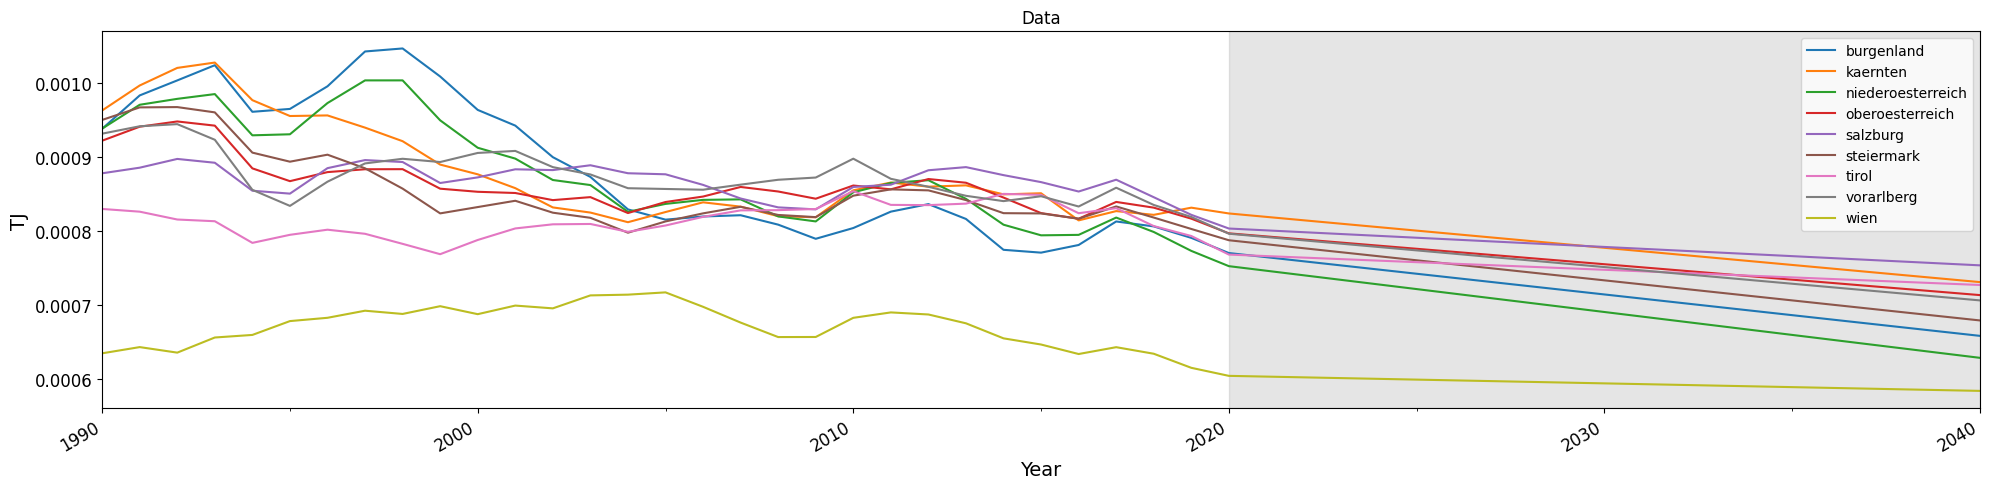

In [20]:
ph_forecast = do_forecast(ph_data_pp_pm2, extrapolation_extension)
plot_forecast(ph_forecast)

In [21]:
def run_scenario(df: pd.DataFrame, wanted: pd.Series):
    et = wanted.name
    
    df_relative = calc_relative(df)
    df_relative_without_et = df_relative.drop(et, axis=1)
    df_relative_without_et_relative = calc_relative(df_relative_without_et)
    
    to_sub = df[et] - wanted
    to_add = (df_relative_without_et_relative.transpose() * to_sub).transpose()
    to_add[et] = to_sub * -1

    result = df + to_add
    result_reordered = result.reindex(columns=df.columns)
    return result_reordered
    
def run_scenarios(df: pd.DataFrame, wanted: pd.DataFrame):
    global_result = df.copy()
    for et in wanted.columns:
        local_result = run_scenario(global_result, wanted[et])
        global_result = local_result.drop(et, axis=1)
    result = pd.concat([global_result, wanted], axis=1)
    result_reordered = result.reindex(columns=df.columns)
    return result_reordered


In [22]:
def create_linear_scenario(series: pd.Series, start: str, end: str, end_value):
    et = series.name
    index = series[start:end][1:].index
    start_value = series[start]
    decrement = (start_value - end_value) / (len(index))
    start_series = series[:start]
    wanted_series = pd.Series([start_value - decrement * (i + 1) for i in range(len(index))], index=index)
    end_series = series[end:][1:]
    result = pd.concat([start_series, wanted_series, end_series])
    result.name = series.name
    return result


In [23]:
def get_energy_pm2_drift(land: str):
    data = ph_forecast[land]
    deltaX = 19
    deltaY = data['2040'] - data['2020']
    return (deltaY / deltaX) / data['2020'] * -100

def get_energy_pm2_drift_all():
    return list([(land.name, get_energy_pm2_drift(land.name)) for land in general_data.laender.values()])

get_energy_pm2_drift_all()

[('burgenland', 0.7648430624231759),
 ('kaernten', 0.5927660608331096),
 ('niederoesterreich', 0.8665931328313373),
 ('oberoesterreich', 0.5512857942052272),
 ('salzburg', 0.3259736774642564),
 ('steiermark', 0.72439162098214),
 ('tirol', 0.2816164409431381),
 ('vorarlberg', 0.5956883349251296),
 ('wien', 0.17692194848040962)]

In [24]:
def create_renovation_scenario(series: pd.Series, start: str, end: str, renovation):
    index = series[start:end][1:].index
    start_value = series[start]
    decrement = start_value * renovation / 100
    start_series = series[:start]
    wanted_series = pd.Series([start_value - decrement * (i + 1) for i in range(len(index))], index=index)
    end_series = series[end:][1:]
    result = pd.concat([start_series, wanted_series, end_series])
    result.name = series.name
    return result

def run_renovation_scenario(df: pd.DataFrame, wanted: pd.Series):
    land = wanted.name
    copy = df.copy()
    copy[land] = wanted
    return copy

In [25]:
renovation_scenario = create_renovation_scenario(ph_forecast['wien'], '2020', '2040', 1)

In [ ]:
ph_forecast_scenario = run_renovation_scenario(ph_forecast, renovation_scenario)

In [48]:
def plot_result(data, scenario):
    matplotlib.rcParams["figure.figsize"] = (20,20)
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['xtick.labelsize'] = 12
    matplotlib.rcParams['ytick.labelsize'] = 12
    matplotlib.rcParams['text.color'] = 'k'

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    data.plot(ax=ax1)
    ax1.set_title('Data')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('TJ')
    ax1.axvspan(since_epoch(data['2020':].index[0]), since_epoch(data.index[-1:][0]), color='#808080', alpha=0.2)

    scenario.plot(ax=ax2)
    ax2.set_title('Szenario')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('TJ')
    ax2.axvspan(since_epoch(scenario['2020':].index[0]), since_epoch(scenario.index[-1:][0]), color='#808080', alpha=0.2)

    fig.autofmt_xdate()
    plt.tight_layout()

    plt.show()

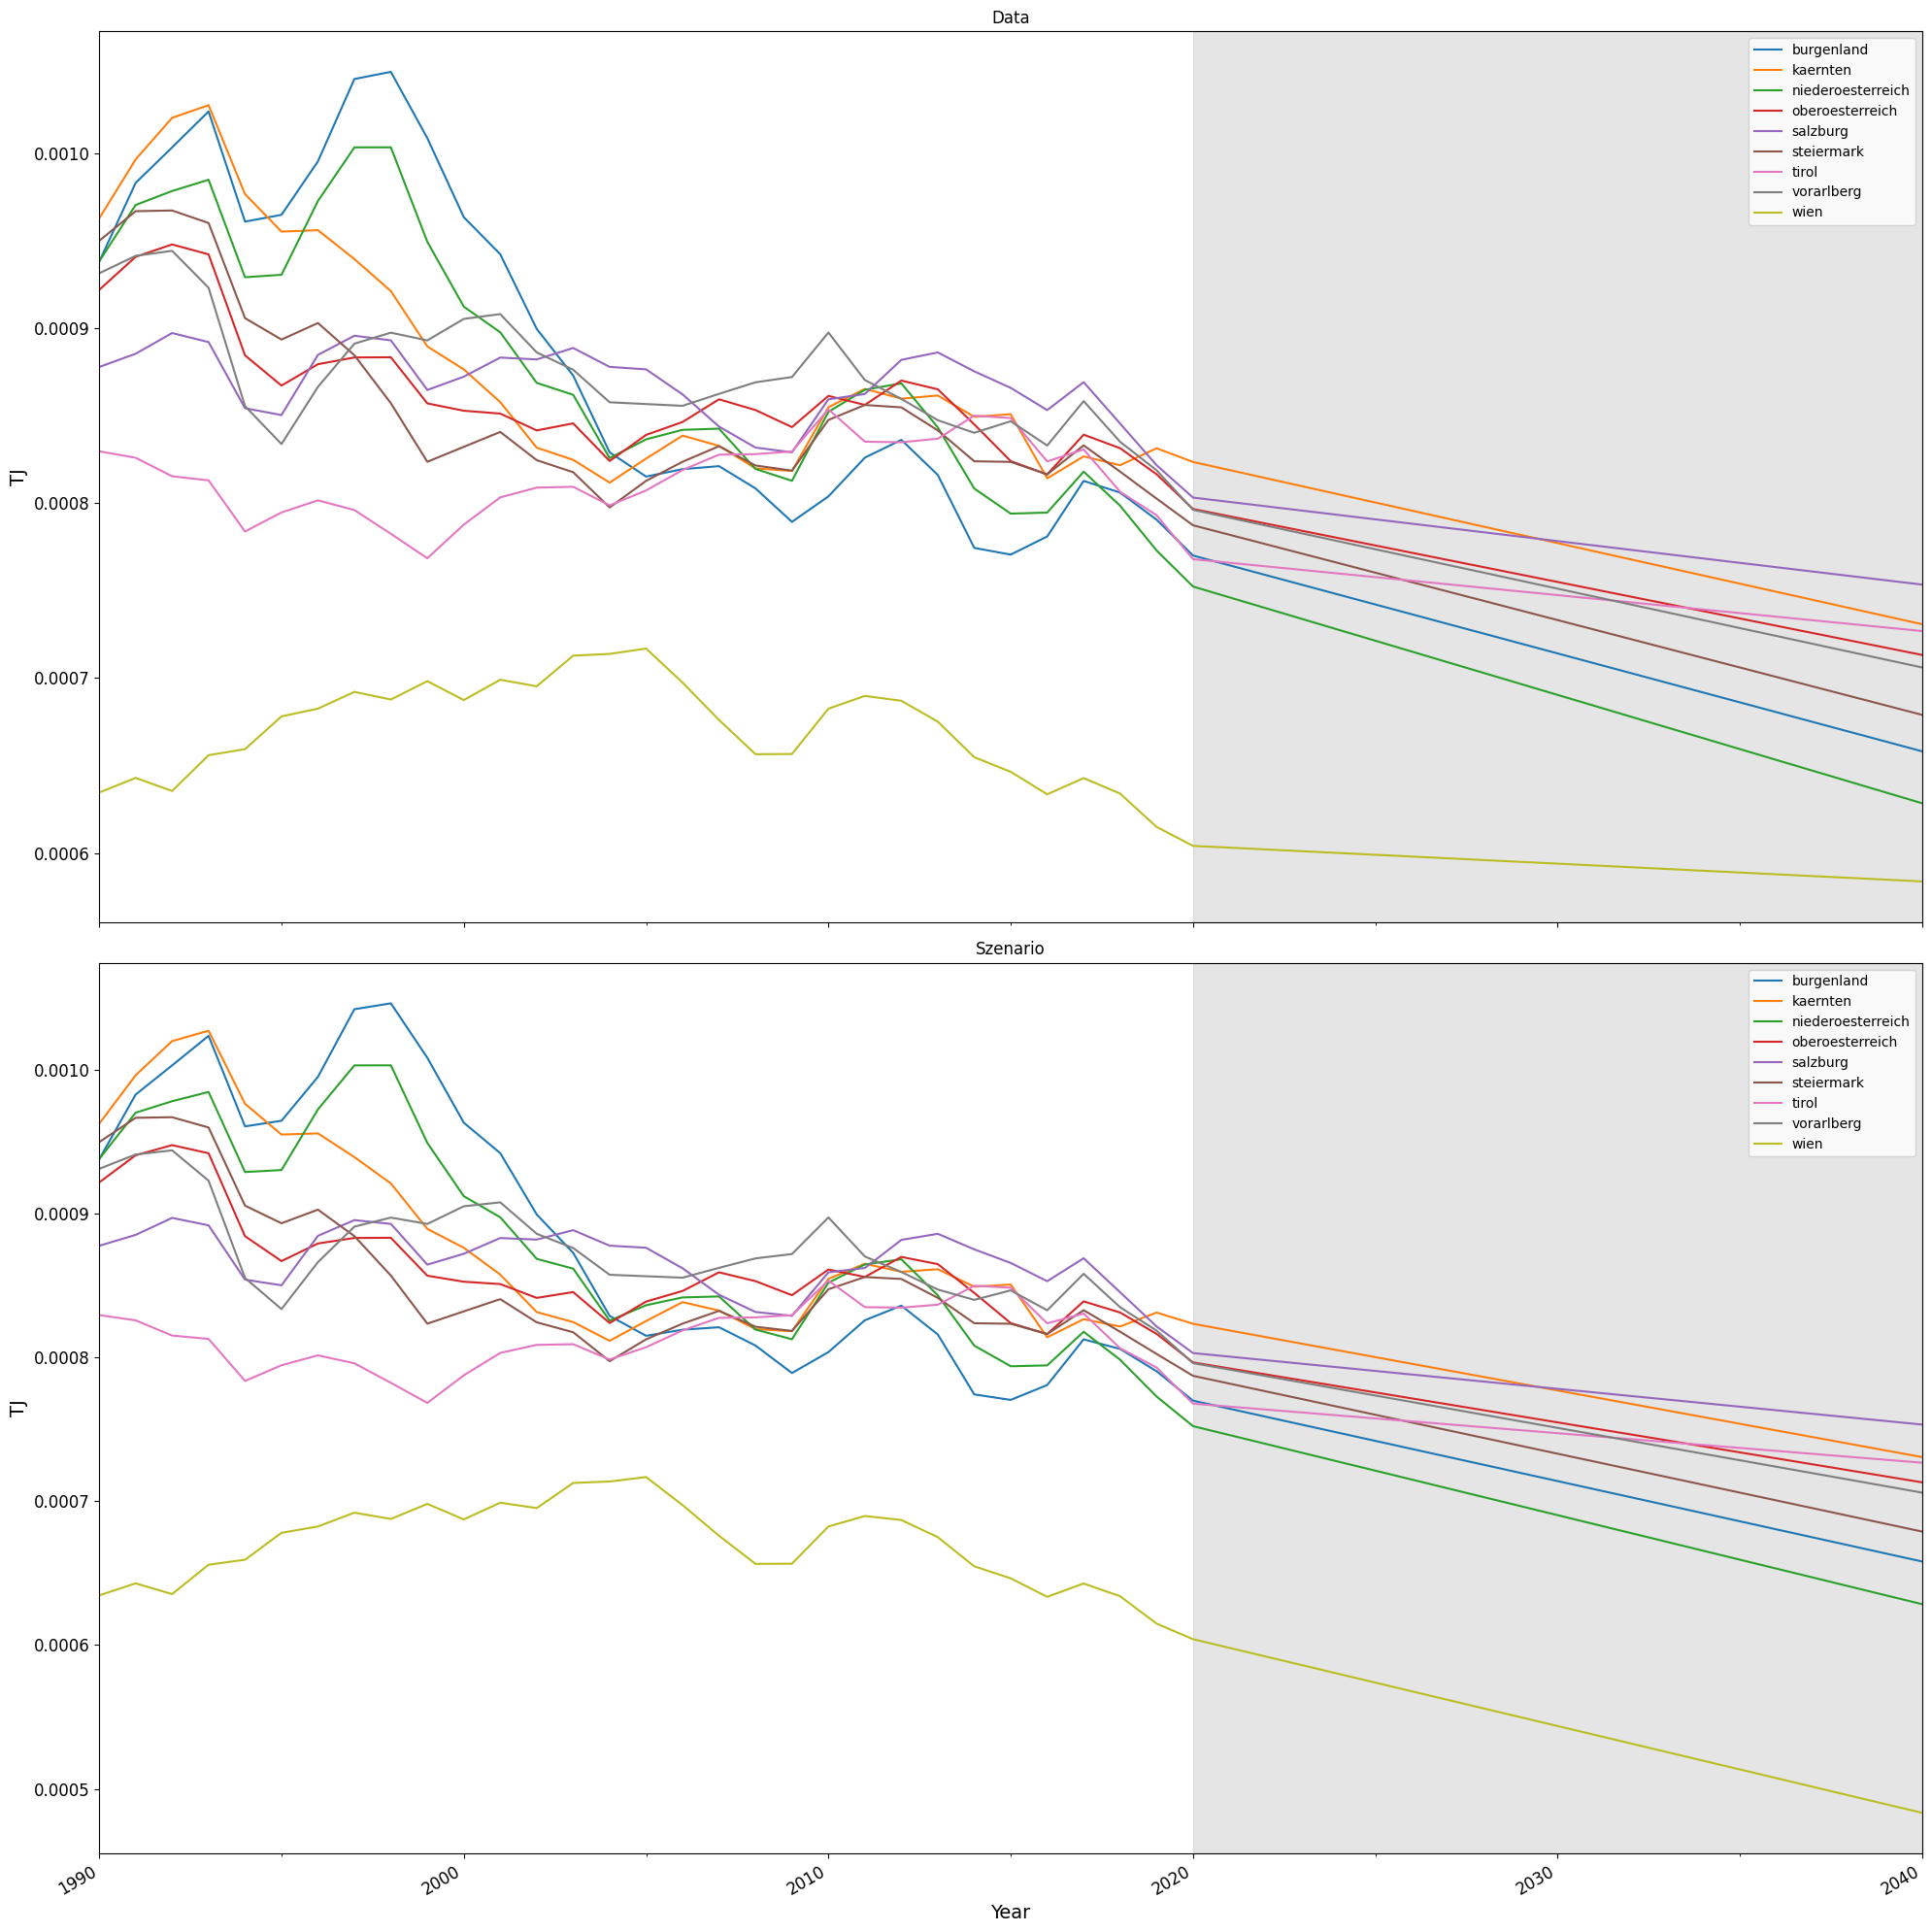

In [49]:
plot_result(ph_forecast, ph_forecast_scenario)

<Axes: >

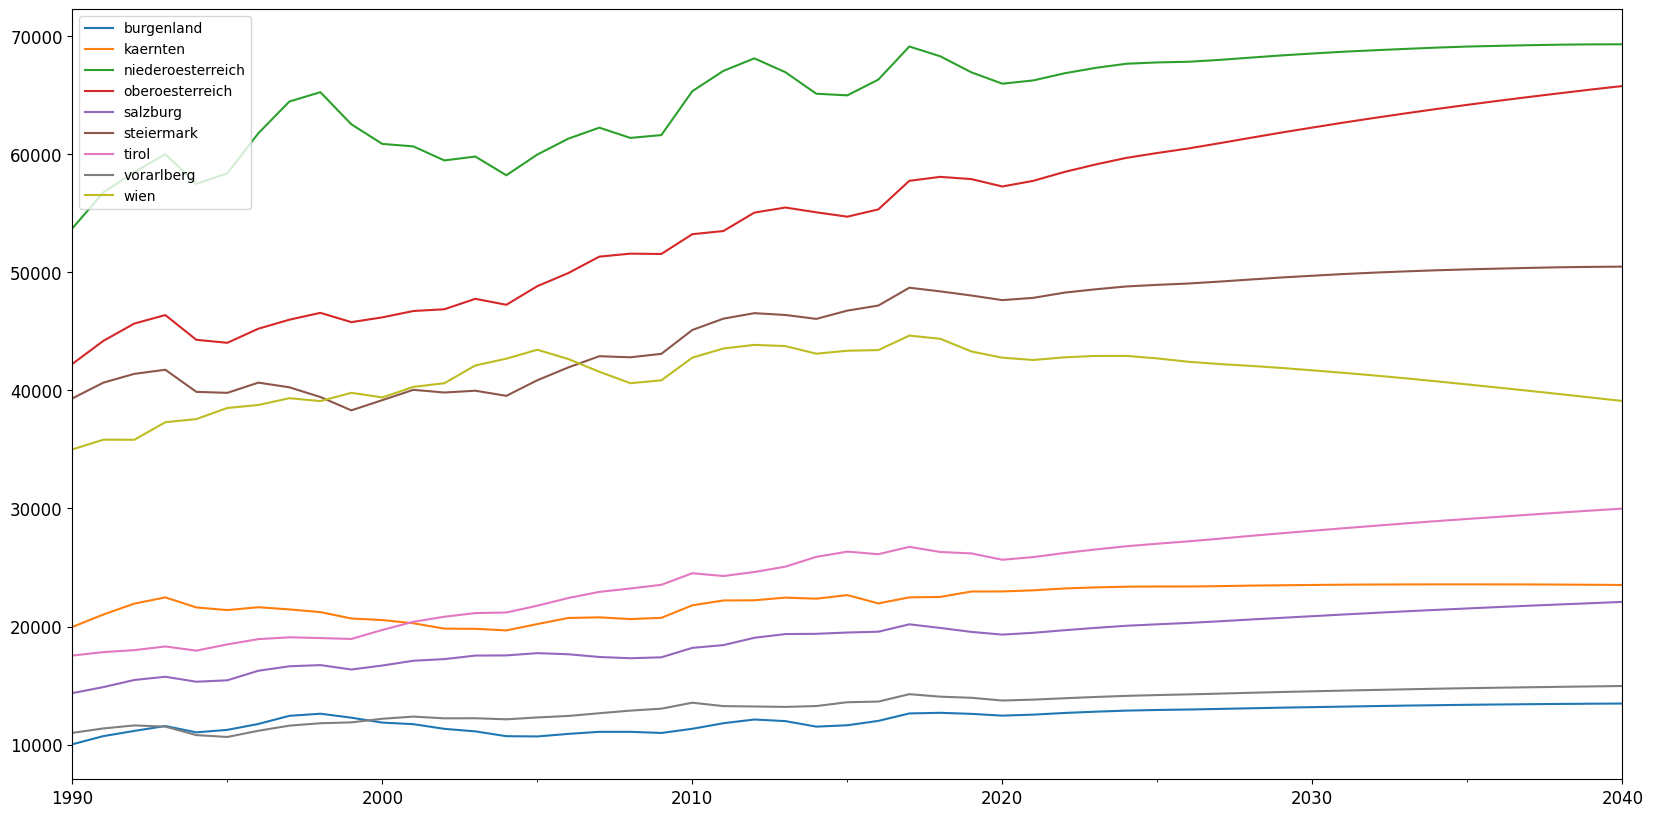

In [28]:
result = (ph_forecast_scenario * df_wohnungsgroesse['1990':'2040'] * create_b_laender().transpose()['1990':'2040'])
result.plot()

In [29]:
def create_test_scenario(df):
    test_scenario_erneuerbare = create_linear_scenario(df['Erneuerbare'], '2020', '2040', 7500)
    
    test_scenario_gas = create_linear_scenario(df['Fossile gasförmig'], '2020', '2040', 0)

    test_scenario_oel = create_linear_scenario(df['Fossile flüssig'], '2020', '2035', 0)
    test_scenario_oel = create_linear_scenario(test_scenario_oel, '2035', '2040', 0)

    test_scenario_kohle = create_linear_scenario(df['Fossile fest'], '2020', '2030', 0)
    test_scenario_kohle = create_linear_scenario(test_scenario_kohle, '2030', '2040', 0)

    return pd.concat([test_scenario_erneuerbare, test_scenario_gas, test_scenario_oel, test_scenario_kohle], axis=1)

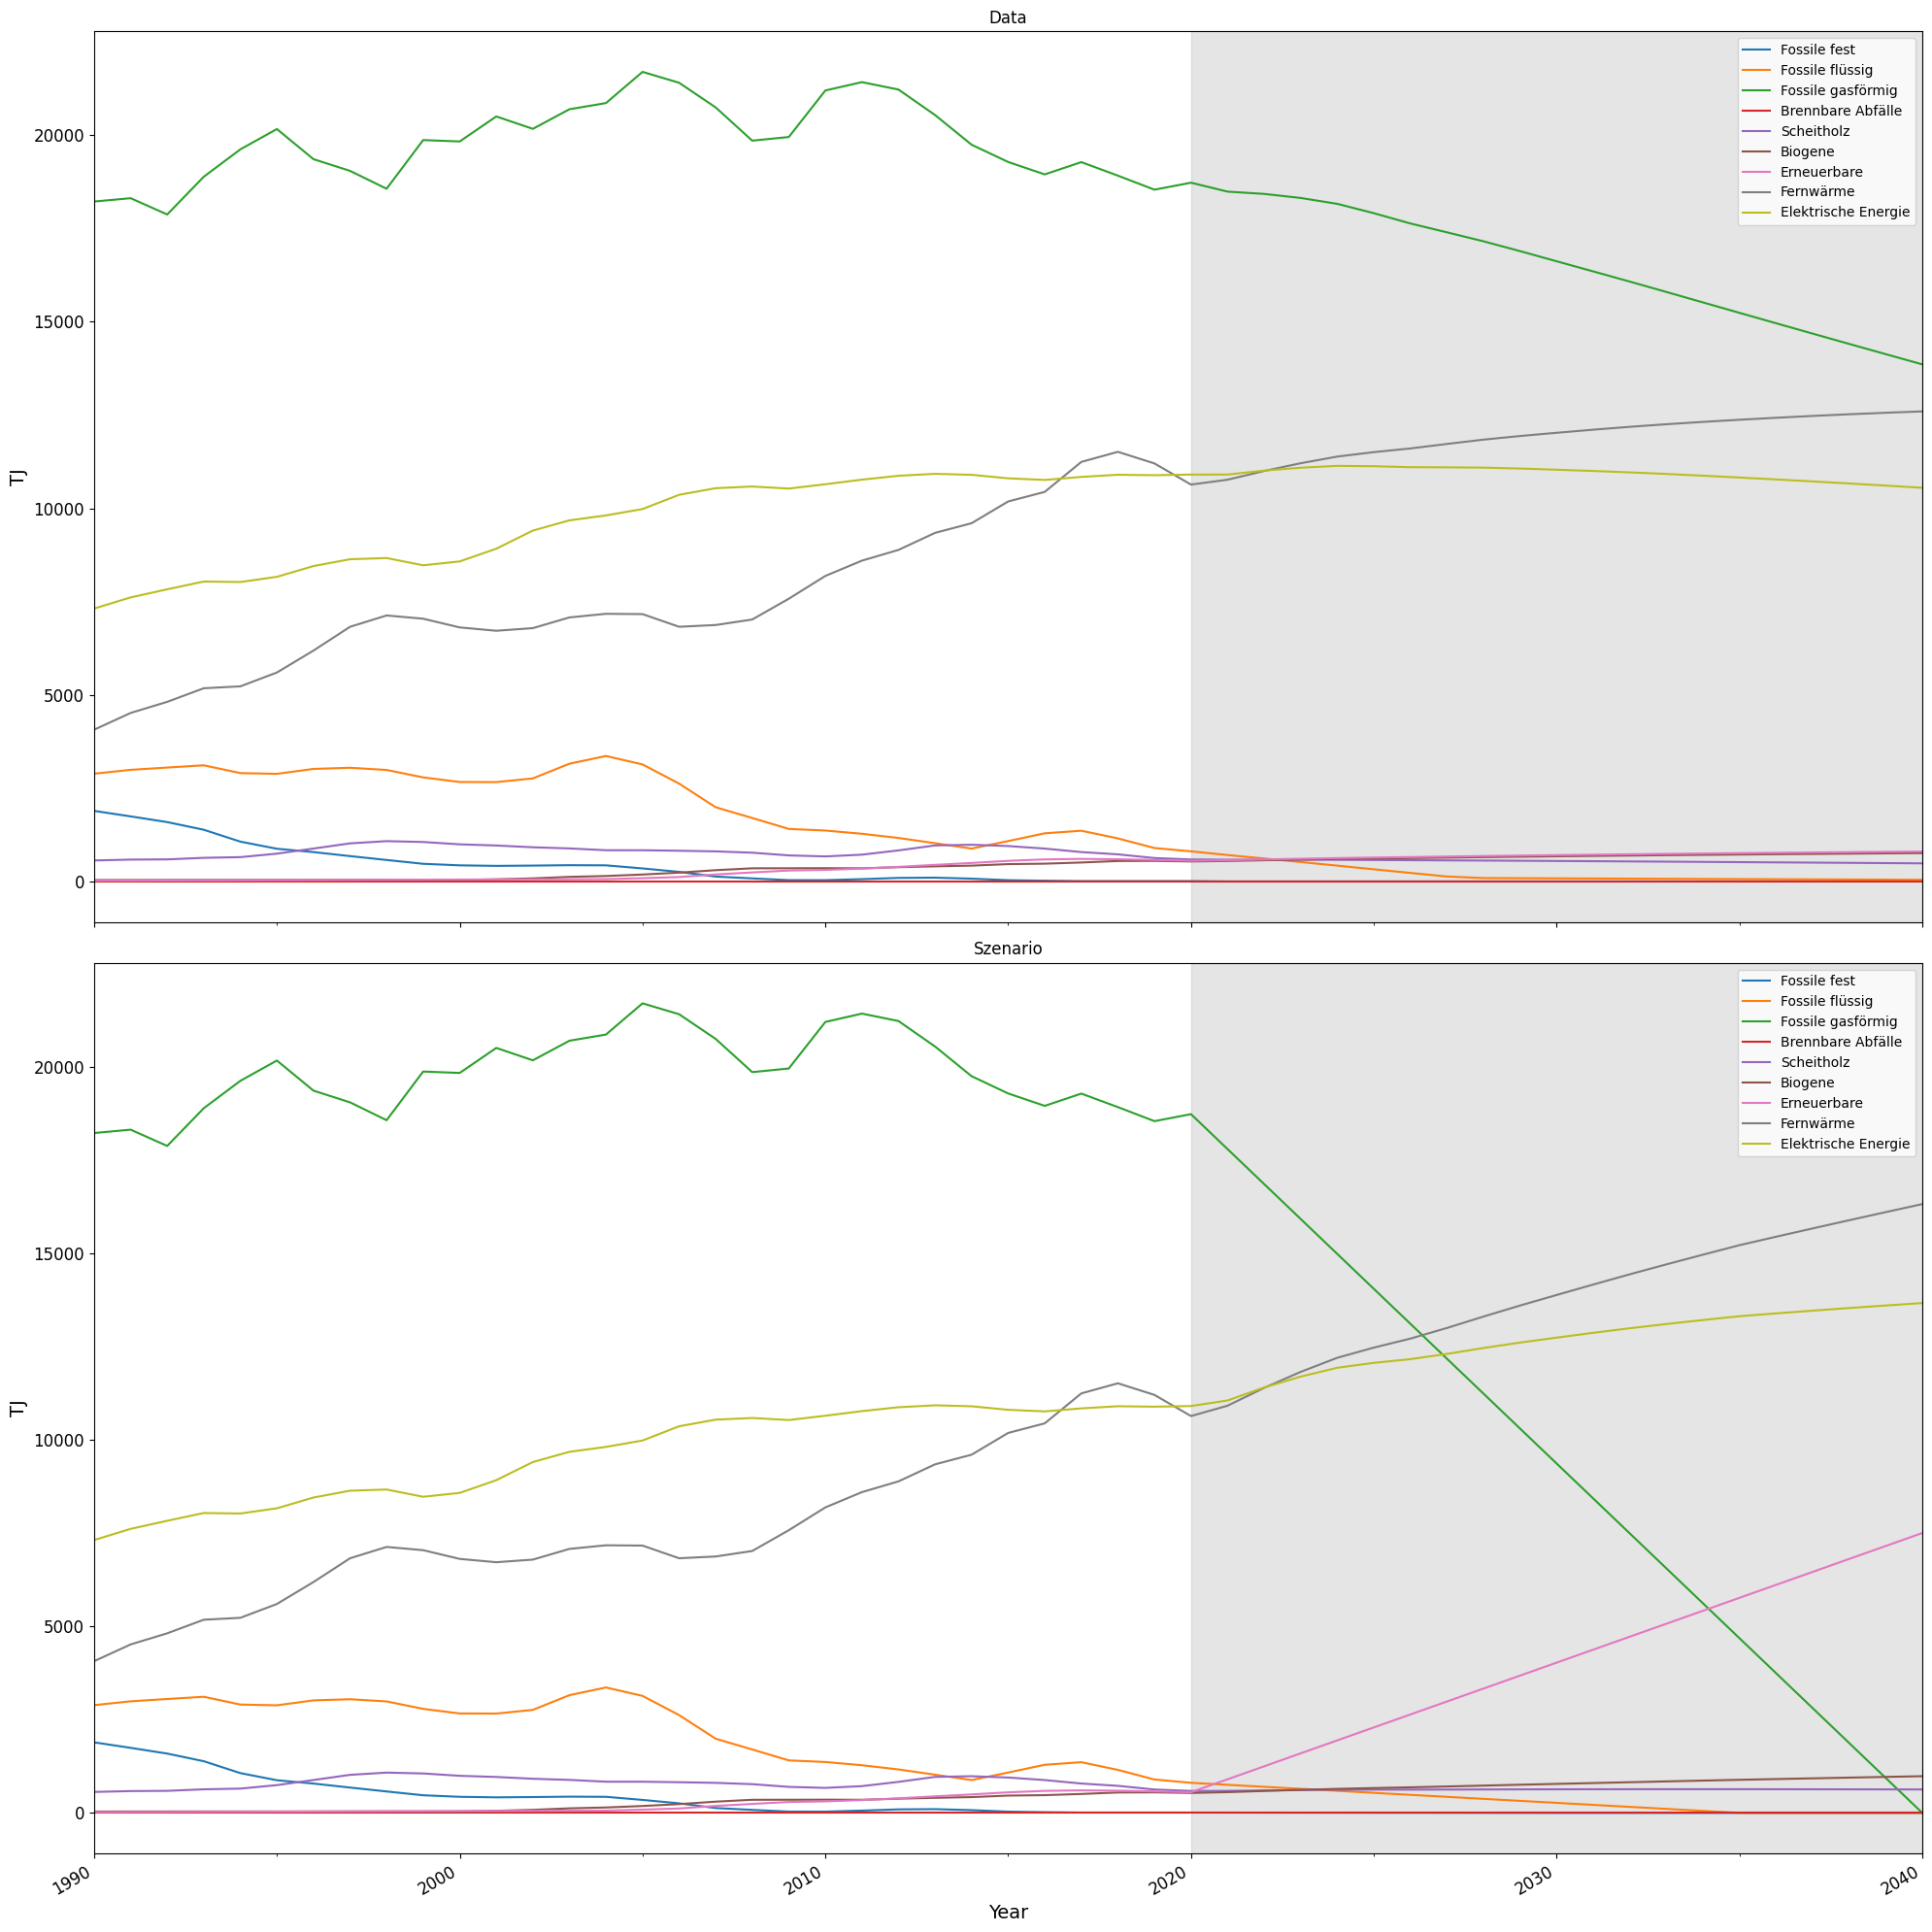

In [50]:
ph_wien = (calc_relative(create_data_sektor_pp_ex('wien', 'Wohngebäude')).transpose() * result['wien']).transpose()

test_scenario_ph_wien = create_test_scenario(ph_wien)
test_scenario_ph_wien_result = run_scenarios(ph_wien, test_scenario_ph_wien)

plot_result(ph_wien, test_scenario_ph_wien_result)

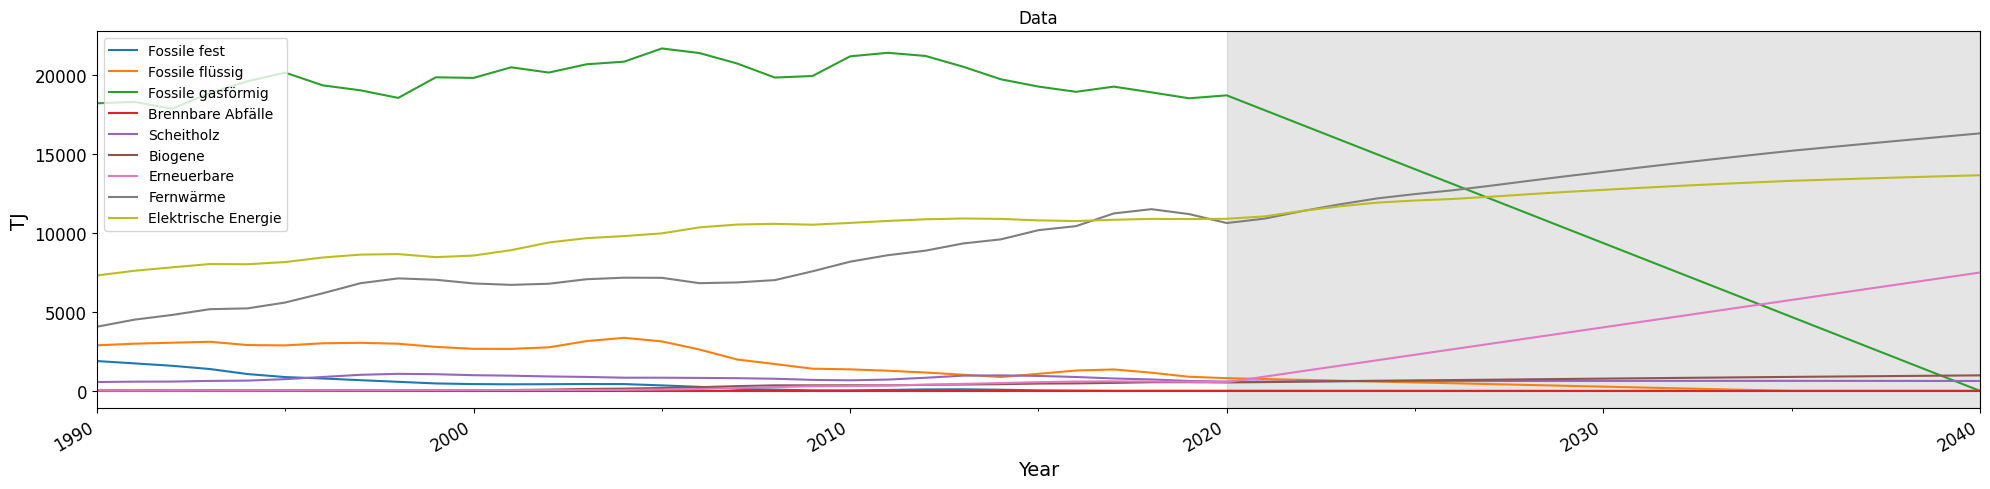

In [31]:
plot_forecast(test_scenario_ph_wien_result)

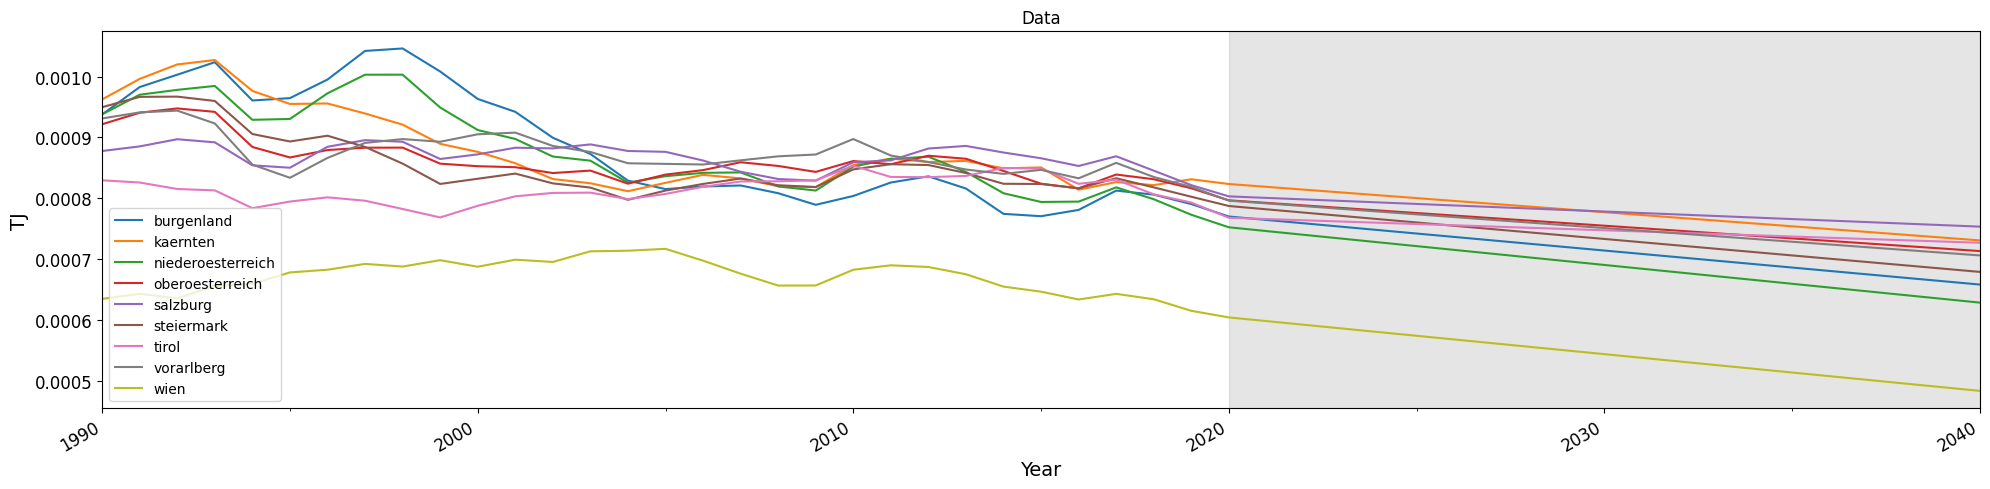

In [33]:
plot_forecast(ph_forecast_scenario)

In [36]:
def plot_population(data):
    matplotlib.rcParams["figure.figsize"] = (20,5)
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['xtick.labelsize'] = 12
    matplotlib.rcParams['ytick.labelsize'] = 12
    matplotlib.rcParams['text.color'] = 'k'

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

    data.plot(ax=ax)
    ax.set_title('Data')
    ax.set_xlabel('Year')
    ax.set_ylabel('Millions')
    ax.axvspan(since_epoch(data['2020':].index[0]), since_epoch(data.index[-1:][0]), color='#808080', alpha=0.2)

    fig.autofmt_xdate()
    plt.tight_layout()

    plt.show()

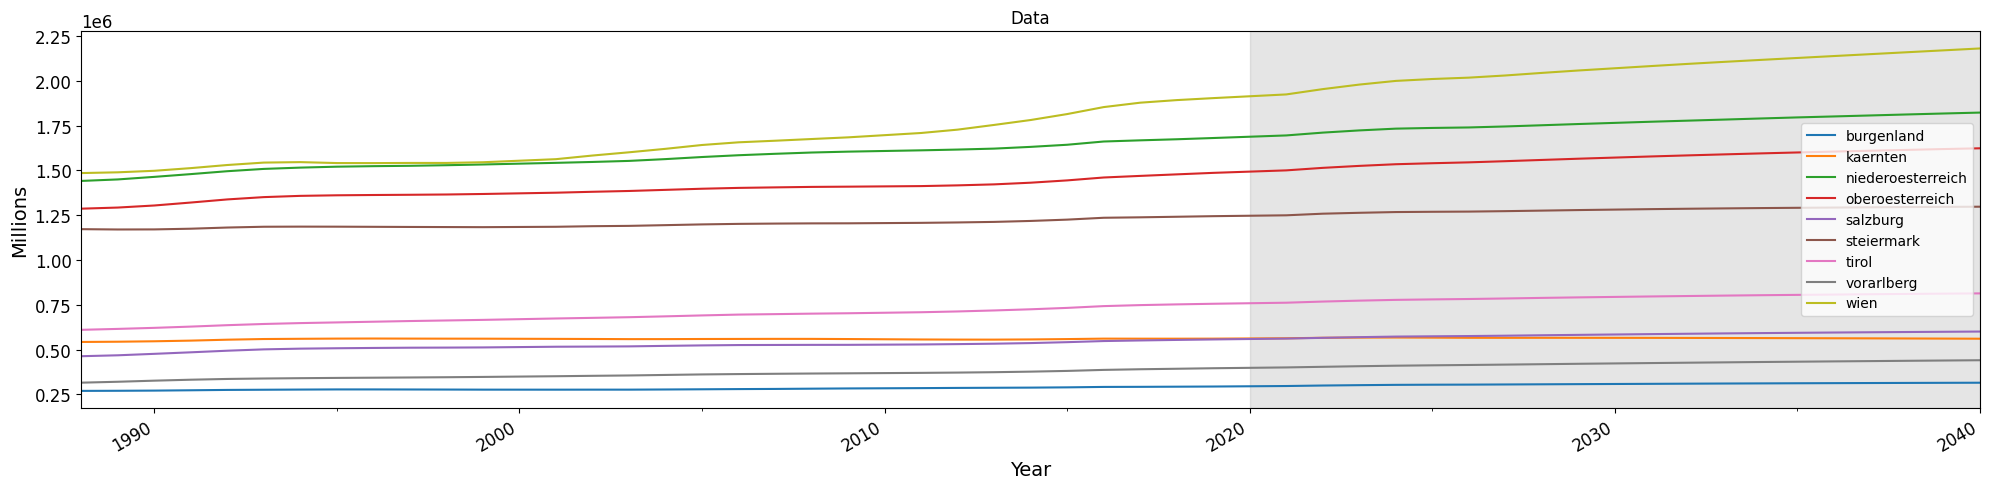

In [37]:
plot_population(create_b_laender().transpose())

In [40]:
def plot_housing_conditions(data):
    matplotlib.rcParams["figure.figsize"] = (20,5)
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['xtick.labelsize'] = 12
    matplotlib.rcParams['ytick.labelsize'] = 12
    matplotlib.rcParams['text.color'] = 'k'

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

    data.plot(ax=ax)
    ax.set_title('Data')
    ax.set_xlabel('Year')
    ax.set_ylabel('m2/Person')
    ax.axvspan(since_epoch(data['2020':].index[0]), since_epoch(data.index[-1:][0]), color='#808080', alpha=0.2)

    fig.autofmt_xdate()
    plt.tight_layout()

    plt.show()

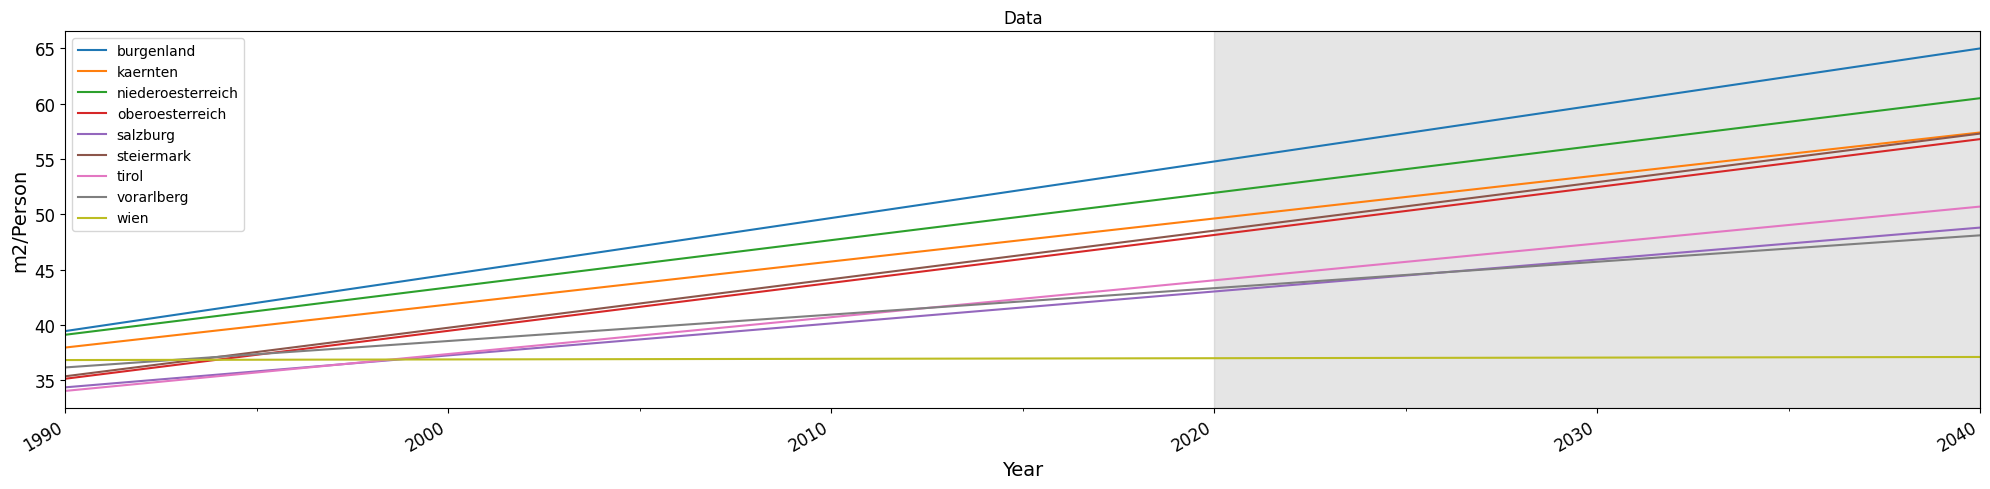

In [41]:
plot_housing_conditions(df_wohnungsgroesse)

In [46]:
def plot_data(data):
    matplotlib.rcParams["figure.figsize"] = (20,8)
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['xtick.labelsize'] = 12
    matplotlib.rcParams['ytick.labelsize'] = 12
    matplotlib.rcParams['text.color'] = 'k'

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

    data.plot(ax=ax)
    ax.set_title('Data')
    ax.set_xlabel('Year')
    ax.set_ylabel('TJ')

    fig.autofmt_xdate()
    plt.tight_layout()

    plt.show()

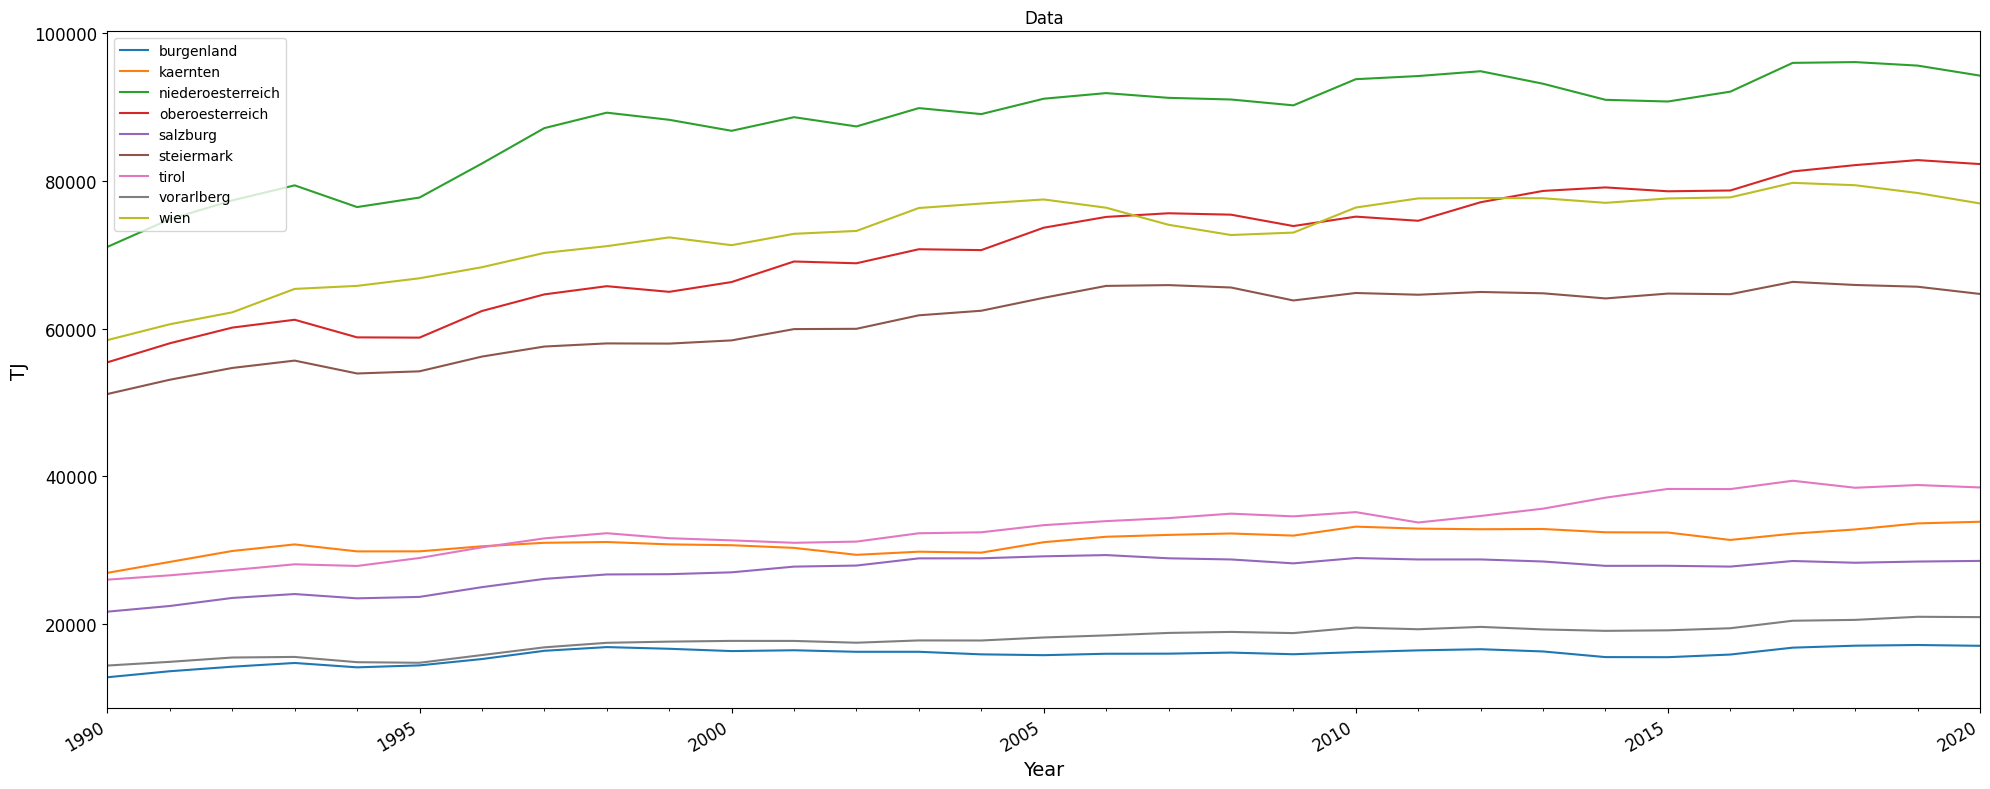

In [47]:
plot_data(create_data_laender_sum())